In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ
from qiskit import execute
from qiskit import Aer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.visualization import plot_histogram

In [1]:
IBMQ.load_account()

In [71]:
# define registers of Alice and Bob
qr_alice = QuantumRegister(2, name='alice')
qr_bob   = QuantumRegister(2, name='bob')
cr_bob   = ClassicalRegister(2, name='bob_c')

# Exercise 5

Implement the quantum circuit of the superdense coding protocol. 
The function **circuit_superdense_coding(x)** takes as its argument x an integer number in \{0,1,2,3\}, which encodes the information that Alice wants to transmit. 

For instance, the output of circuit_superdense_coding(0) should be
```text
          ░                              ░       
alice_0: ─░─────────────────■────────────░───────
          ░                 │            ░       
alice_1: ─░─────────────■───┼────────────░───────
          ░ ┌───┐     ┌─┴─┐ │      ┌───┐ ░ ┌─┐   
  bob_0: ─░─┤ H ├──■──┤ X ├─■───■──┤ H ├─░─┤M├───
          ░ └───┘┌─┴─┐└───┘   ┌─┴─┐└───┘ ░ └╥┘┌─┐
  bob_1: ─░──────┤ X ├────────┤ X ├──────░──╫─┤M├
          ░      └───┘        └───┘      ░  ║ └╥┘
bob_c: 2/═══════════════════════════════════╩══╩═
                                            0  1 
```
and the output of circuit_superdense_coding(2) should be
```text
               ░                              ░       
alice_0: ──────░─────────────────■────────────░───────
         ┌───┐ ░                 │            ░       
alice_1: ┤ X ├─░─────────────■───┼────────────░───────
         └───┘ ░ ┌───┐     ┌─┴─┐ │      ┌───┐ ░ ┌─┐   
  bob_0: ──────░─┤ H ├──■──┤ X ├─■───■──┤ H ├─░─┤M├───
               ░ └───┘┌─┴─┐└───┘   ┌─┴─┐└───┘ ░ └╥┘┌─┐
  bob_1: ──────░──────┤ X ├────────┤ X ├──────░──╫─┤M├
               ░      └───┘        └───┘      ░  ║ └╥┘
bob_c: 2/════════════════════════════════════════╩══╩═
                                                 0  1 
```

In [72]:
def encode_classical_information(x, qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc (assumed to be
    in the state |0...0>) such that the integer number x 
    in {0,1,2,3} is encoded into the quantum state
    """
    if x%4 == 1:
        qc.x(qubit0)
    elif x%4 == 2:
        qc.x(qubit1)
    elif x%4 == 3:
        qc.x(qubit0)
        qc.x(qubit1)
    
    return qc

qc = QuantumCircuit(qr_alice, qr_bob)
encode_classical_information(1, qc, qr_alice[0], qr_alice[1]).draw()

┌───┐
alice_0: ┤ X ├
         └───┘
alice_1: ─────
              
  bob_0: ─────
              
  bob_1: ─────

In [74]:
def generate_Bell_state(qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc
    to generate a Bell state
    """
    qc.h(qubit0)
    qc.cnot(qubit0, qubit1)
    
    return qc

qc = QuantumCircuit(qr_alice, qr_bob)
generate_Bell_state(qc, qr_bob[0], qr_bob[1]).draw()

alice_0: ──────────
                   
alice_1: ──────────
         ┌───┐     
  bob_0: ┤ H ├──■──
         └───┘┌─┴─┐
  bob_1: ─────┤ X ├
              └───┘

In [76]:
def analyze_Bell_state(qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc
    to analyze a given Bell state
    """
    qc.cnot(qubit0, qubit1)
    qc.h(qubit0)
    
    return qc

qc = QuantumCircuit(qr_alice, qr_bob)
analyze_Bell_state(qc, qr_bob[0], qr_bob[1]).draw()

alice_0: ──────────
                   
alice_1: ──────────
              ┌───┐
  bob_0: ──■──┤ H ├
         ┌─┴─┐└───┘
  bob_1: ┤ X ├─────
         └───┘

In [77]:
def transmission(qc, qubit0, qubit1, qubit2):
    """
    append gates to the quantum circuit qc
    such that Alice can transform Bob's Bell
    state into any other Bell state
    """
    qc.cnot(qubit1, qubit2)
    qc.cz(qubit0, qubit2)
    
    return qc

qc = QuantumCircuit(qr_alice, qr_bob)
transmission(qc, qr_alice[0], qr_alice[1], qr_bob[0]).draw()

alice_0: ──────■─
               │ 
alice_1: ──■───┼─
         ┌─┴─┐ │ 
  bob_0: ┤ X ├─■─
         └───┘   
  bob_1: ────────

In [121]:
def circuit_superdense_coding(x):
    """
    the full quantum circuit to implement a superdense
    coding protocol between Alice and Bob
    """
    # quantum register with Alice's qubits
    qr_alice = QuantumRegister(2, name='alice')
    # quantum register with Bob's qubits
    qr_bob   = QuantumRegister(2, name='bob')
    # classical register for Bob's measurements
    cr_bob   = ClassicalRegister(2, name='bob_c')
    
    # define the circuit
    qc = QuantumCircuit(qr_alice, qr_bob, cr_bob)
    qc = encode_classical_information(x, qc, qr_alice[0], qr_alice[1])
    qc.barrier()
    qc = prepare_Bell_state(qc, qr_bob[0], qr_bob[1])
    qc = transmission(qc, qr_alice[0], qr_alice[1], qr_bob[0])
    qc = analyze_Bell_state(qc, qr_bob[0], qr_bob[1])
    qc.barrier()
    qc.measure(qr_bob[0], cr_bob[0])
    qc.measure(qr_bob[1], cr_bob[1])
    
    # return the circuit
    return qc

qc = circuit_superdense_coding(2)
qc.draw()

░                              ░       
alice_0: ──────░─────────────────■────────────░───────
         ┌───┐ ░                 │            ░       
alice_1: ┤ X ├─░─────────────■───┼────────────░───────
         └───┘ ░ ┌───┐     ┌─┴─┐ │      ┌───┐ ░ ┌─┐   
  bob_0: ──────░─┤ H ├──■──┤ X ├─■───■──┤ H ├─░─┤M├───
               ░ └───┘┌─┴─┐└───┘   ┌─┴─┐└───┘ ░ └╥┘┌─┐
  bob_1: ──────░──────┤ X ├────────┤ X ├──────░──╫─┤M├
               ░      └───┘        └───┘      ░  ║ └╥┘
bob_c: 2/════════════════════════════════════════╩══╩═
                                                 0  1

<hr>

# Exercise 6

Let's assume we want to execute the circuit on the quantum computer **ibmq_rome**. 
Read out it's noise model, coupling map, and basis gates. 
Choose a reasonable layout how to map the virtual circuit on the physical device and implement the transpilation. 
Simulate the transpiled circuit with the QASM_simulator. 

In [ ]:
# select a real quantum computer and read out its (current!) noise properties
backend = IBMQ.get_provider('ibm-q').get_backend('ibmq_rome')
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = backend.configuration().basis_gates

In [88]:
# choose a reasonable layout
layout = { qr_alice[0] : 1,
           qr_alice[1] : 2,
           qr_bob[0]   : 3,
           qr_bob[1]   : 4 }

In [89]:
# generate the superdense coding circuits
circuits = [ circuit_superdense_coding(x) for x in range(4) ]

In [90]:
# transpile circuit
circuits_transpiled = transpile(circuits, 
                                backend=backend, 
                                basis_gates=basis_gates, 
                                coupling_map=coupling_map, 
                                initial_layout=layout) 

In [91]:
# visualize a circuit
circuits_transpiled[1].draw()

»
ancilla_0 -> 0 ───────────────────────────────────────────────────────────────»
               ┌───────────┐ ░                           ┌───┐                »
  alice_0 -> 1 ┤ U3(π,0,π) ├─░────────────────────────■──┤ X ├──■─────────────»
               └───────────┘ ░                      ┌─┴─┐└─┬─┘┌─┴─┐           »
  alice_1 -> 2 ──────────────░───────────────────■──┤ X ├──■──┤ X ├───────────»
                             ░ ┌─────────┐     ┌─┴─┐└───┘┌───┐└───┘           »
    bob_0 -> 3 ──────────────░─┤ U2(0,π) ├──■──┤ X ├──■──┤ X ├──■─────────────»
                             ░ └─────────┘┌─┴─┐└───┘┌─┴─┐└─┬─┘┌─┴─┐┌─────────┐»
    bob_1 -> 4 ──────────────░────────────┤ X ├─────┤ X ├──■──┤ X ├┤ U2(0,π) ├»
                             ░            └───┘     └───┘     └───┘└─────────┘»
      bob_c: 2/═══════════════════════════════════════════════════════════════»
                                                                              »
«                                                ░       
«ancilla_0 -> 0 ─────────────────────────────────░───────
«                                                ░       
«  alice_0 -> 1 ─────────────────────────────────░───────
«                                                ░       
«  alice_1 -> 2 ──■──────────────────────────────░───────
«                 │             ┌───┐            ░    ┌─┐
«    bob_0 -> 3 ──┼─────────────┤ X ├────────────░────┤M├
«               ┌─┴─┐┌─────────┐└─┬─┘┌─────────┐ ░ ┌─┐└╥┘
«    bob_1 -> 4 ┤ X ├┤ U2(0,π) ├──■──┤ U2(0,π) ├─░─┤M├─╫─
«               └───┘└─────────┘     └─────────┘ ░ └╥┘ ║ 
«      bob_c: 2/════════════════════════════════════╩══╩═
«                                                   0  1

In [92]:
# simulate the transpiled circuit
job_transpiled = execute(circuits_transpiled, Aer.get_backend('qasm_simulator'), shots=8192, 
                         backend_properties=backend.properties(),
                         noise_model=noise_model)
results_transpiled = job_transpiled.result()

In [100]:
# visualize results
plot_histogram(results_transpiled.get_counts(), 
               legend=[str(bin(x))[2:].zfill(2) for x in range(len(circuits))],
               bar_labels=False)

<hr>

# Exercise 7

Implement a measurement mitigation step. 
Transpile the calibration circuits according to the layout you chose in the previous exercise and simulate them using the QASM_simulator.
Use this calibration run to perform a measurement mitigation on your results from the previous exercise

In [104]:
# construct a set of calibration circuits to benchmark the readout process
calibration_circuts, calibration_labels = complete_meas_cal([0,1], qr_bob, cr_bob, circlabel='meas_cal')

In [106]:
# transpile circuit
calibration_circuits_transpiled = transpile(
    calibration_circuts, backend=backend, 
    basis_gates=basis_gates, 
    coupling_map=coupling_map, 
    initial_layout=layout) 

In [108]:
# visualize the circuit
calibration_circuits_transpiled[3].draw()

ancilla_0 -> 0 ──────────────────────
                                     
  alice_0 -> 1 ──────────────────────
                                     
  alice_1 -> 2 ──────────────────────
               ┌───────────┐ ░ ┌─┐   
    bob_0 -> 3 ┤ U3(π,0,π) ├─░─┤M├───
               ├───────────┤ ░ └╥┘┌─┐
    bob_1 -> 4 ┤ U3(π,0,π) ├─░──╫─┤M├
               └───────────┘ ░  ║ └╥┘
      bob_c: 2/═════════════════╩══╩═
                                0  1

In [109]:
# simulate the circuits with a realistic noise model
result_calibration = execute(calibration_circuits_transpiled, Aer.get_backend('qasm_simulator'), shots=8192, 
                             backend_properties=backend.properties(),
                             noise_model=noise_model)

In [115]:
# analyze the results
measurement_fitter = CompleteMeasFitter(result_calibration.result(), calibration_labels, circlabel='meas_cal')
print (np.around(measurement_fitter.cal_matrix,2))
measurement_fitter.plot_calibration()

[[0.93 0.08 0.05 0.  ]
 [0.04 0.89 0.   0.05]
 [0.03 0.   0.91 0.08]
 [0.   0.03 0.04 0.86]]


In [112]:
# apply the correction procedure to the results
results_transpiled_mitigated = measurement_fitter.filter.apply(results_transpiled)

In [118]:
# visualize the results without error mitigation
plot_histogram(results_transpiled.get_counts(), 
               legend=[str(bin(x))[2:].zfill(2) for x in range(len(circuits))],
               bar_labels=False,
               title='raw data')

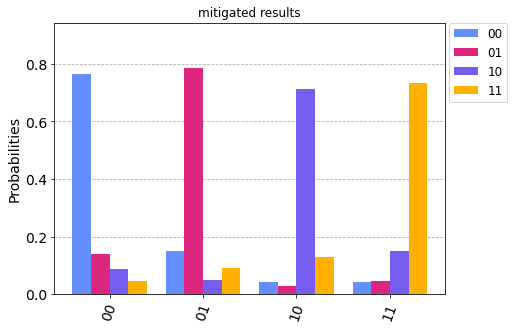

In [119]:
# visualize the results with error mitigation
plot_histogram(results_transpiled_mitigated.get_counts(), 
               legend=[str(bin(x))[2:].zfill(2) for x in range(len(circuits))],
               bar_labels=False,
               title='mitigated results')

<hr>

# Bonus exercise

Rewrite your above results to execute the measurement calibration circuits and the superdense coding protocol in a single job. 
In this way, you can ensure that everything is executed in one go, which is important if you are submitting jobs to the real device. 

<hr>